<h1> draft for intial data Analysis </h1>

This notebook contain drafts for analysis functions, plotting functions, and scripts for the 6OHDA project

import modules and files:

In [240]:
%matplotlib notebook 
%load_ext autoreload
%autoreload 2


#inline
import os
#os.chdir('C:\\Users\\zemel\\Documents\\Reaserch\\PythonProjects\\6OHDA')
#import mpld3
#mpld3.enable_notebook()
import numpy as np
import scipy as sci
from scipy import signal
from scipy.signal import butter
from scipy import interpolate 
from matplotlib import pyplot as plt
from matplotlib import gridspec
import sys
import h5py
from IO import *
from utils import *
from plotUtils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


collect data from all mice, and plot beta power over group by day:

In [3]:
data = getData('Processed.h5',['lfp','mvmt'],period ='Pre',day = lambda x: int(x)==0)

cleaning up lfp data
I deleted session: 1793_BaselineS
I deleted session: 8815_BaselineA
cleaning up mvmt data


In [4]:
def getPowerSpec(lfpDict):
    # This function takes in a dict with lfp data (that was returned from getData())
    # and returns the average power spectra
    # Inputs: 
    #   lfpDict - a dictionary with lfp data as returned from getData()
    # Outputs:
    #   M - mean power spectra
    #   Std - standard diviation of power spectra
    #   f - frequency list

    data = []
    for j in lfpDict:
        lfp = lfpDict[j]['lfp']['lfp']
        f, t, Sxx = signal.spectrogram(lfp[0,:],lfpDict[j]['lfp']['FS'],window=('hamming'),nperseg=140,noverlap =120,nfft=1200)

        Power = np.sum(Sxx,1)
        totPower = np.sum(Power)
        #beta = np.mean(getPowerInBand(f,Sxx,13,20)/np.sum(Sxx,axis = 0)
        data.append(Power/totPower)    



    data = np.array(data)
    M = np.mean(data,axis=0)
    Std = np.std(data, axis = 0)
    return M, Std, f

<h2> Find movment onset and plot speed vs. movment onset for sessions: </h2>

<IPython.core.display.Javascript object>


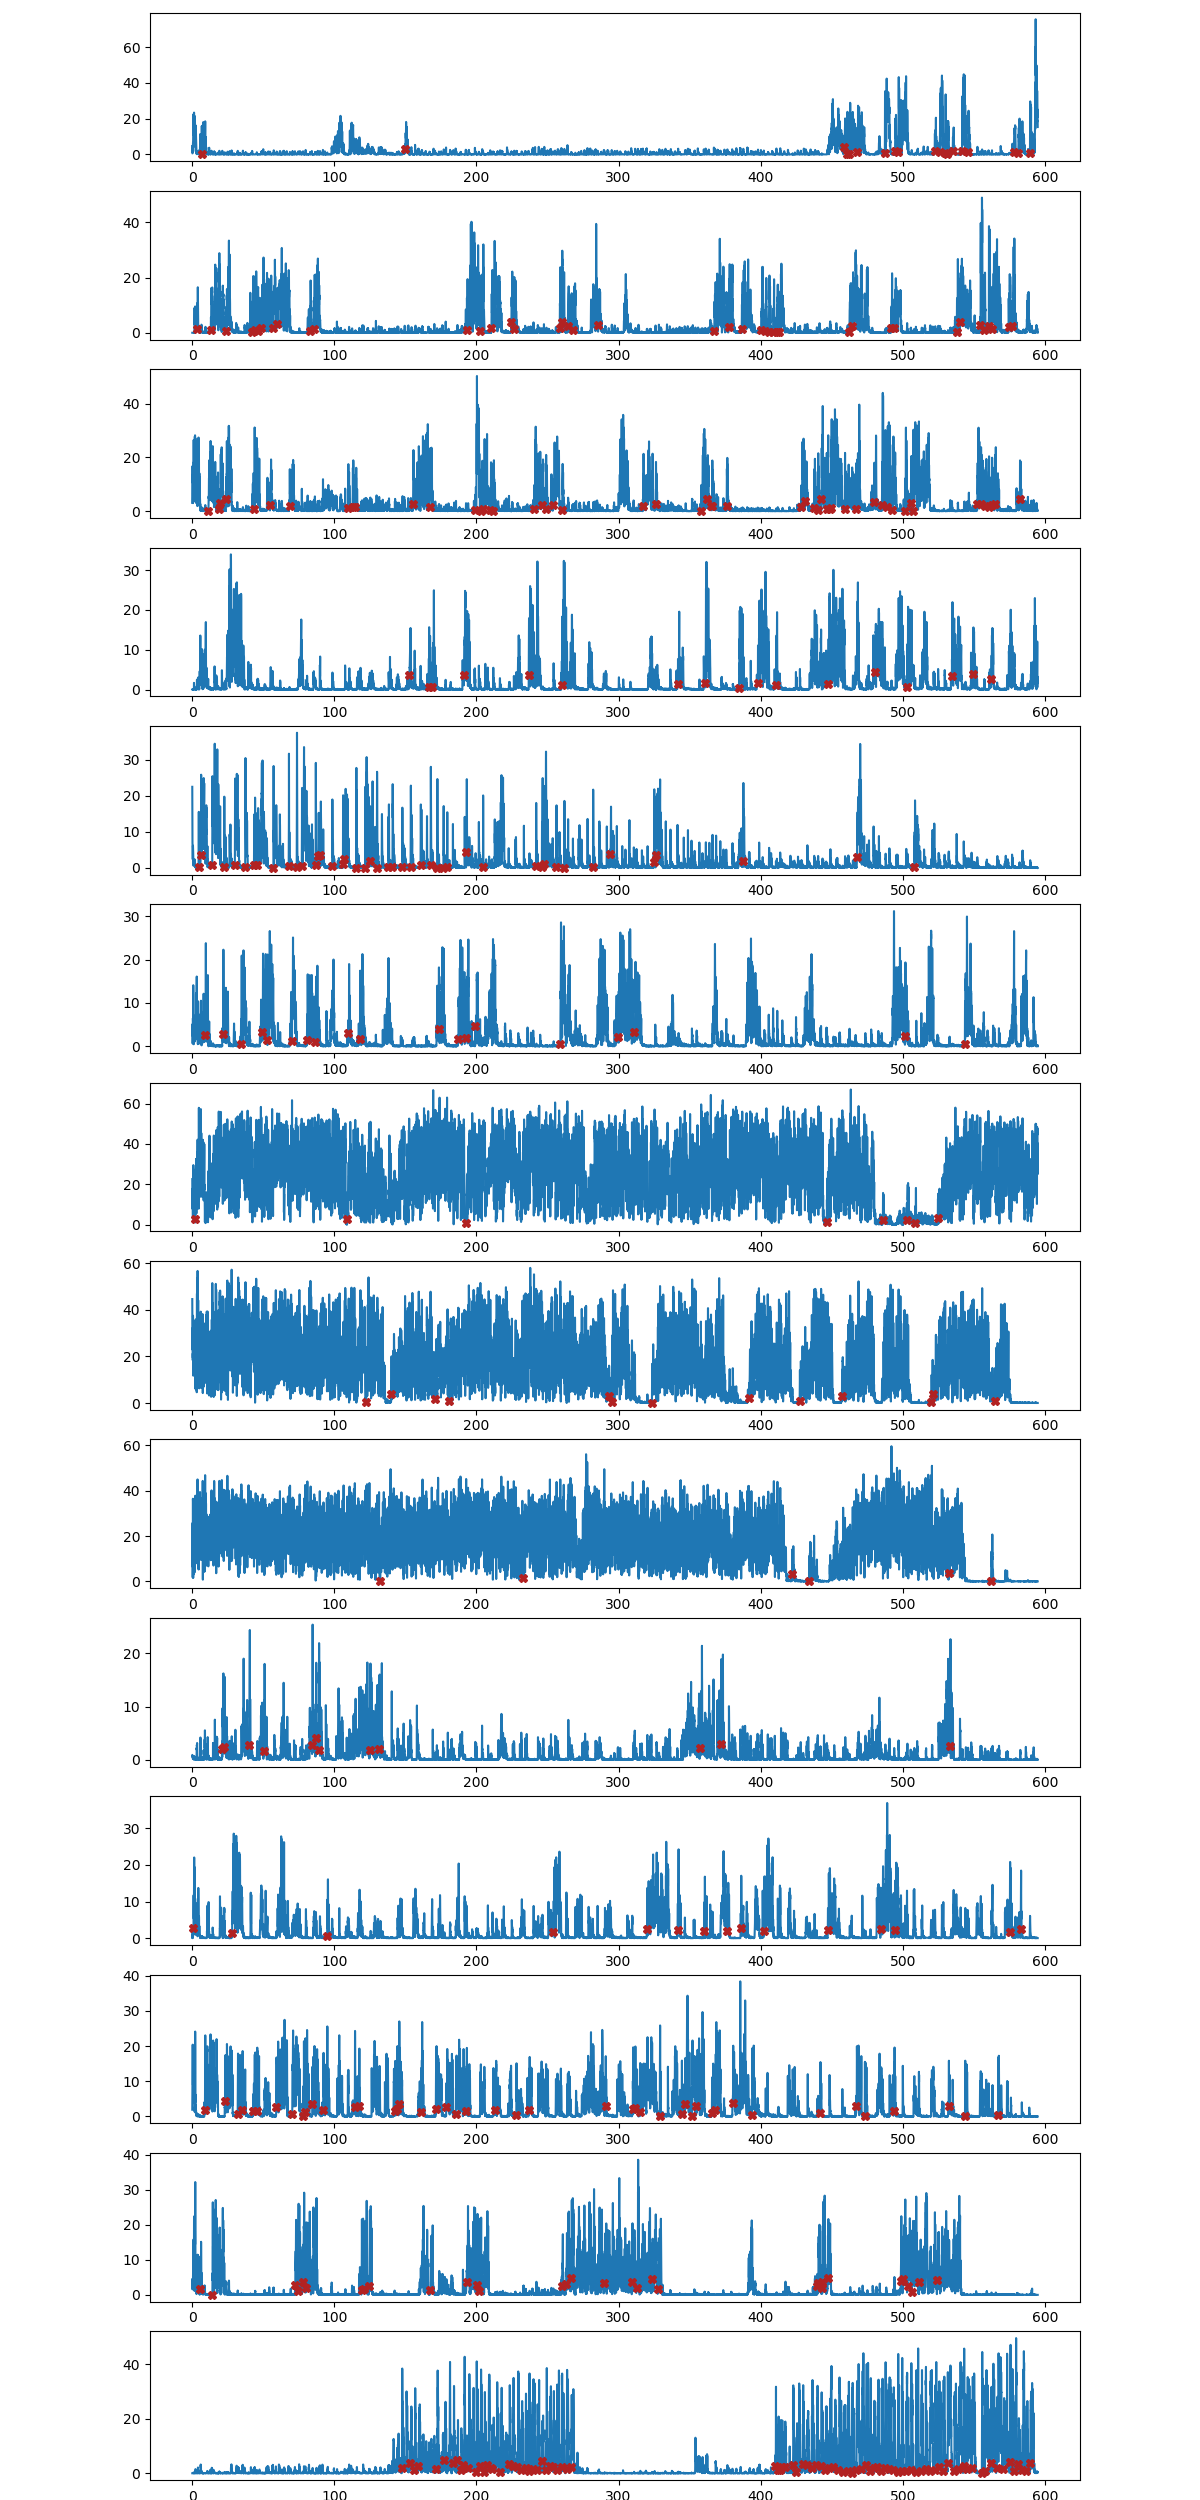

In [57]:
fig, ax = plt.subplots(len(data.keys()),1,figsize=(12, 25),gridspec_kw = {'top':0.995,'bottom':0.008,'wspace':0.3})

de = {}

dt = 1/data['1208_BaselineA']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
#tPlot = np.linspace(-40*dt,40*dt,80)

sessNum = 0
for s in data.keys():
    #find movment onset:
    sOnset = FindMvmtOnset(data[s]['mvmt']['speed'],th =5,hi = 15)   
    # plot speed vd. onset:
    t = np.linspace(0,len(data[s]['mvmt']['speed'])*dt,len(data[s]['mvmt']['speed']))
    ax[sessNum].plot(t,data[s]['mvmt']['speed'])
    ax[sessNum].plot(t[sOnset],data[s]['mvmt']['speed'][sOnset],'X',color='firebrick')
    sessNum = sessNum +1

<h2> look at freqency vs. movment onset - Spectogram </h2>

<IPython.core.display.Javascript object>


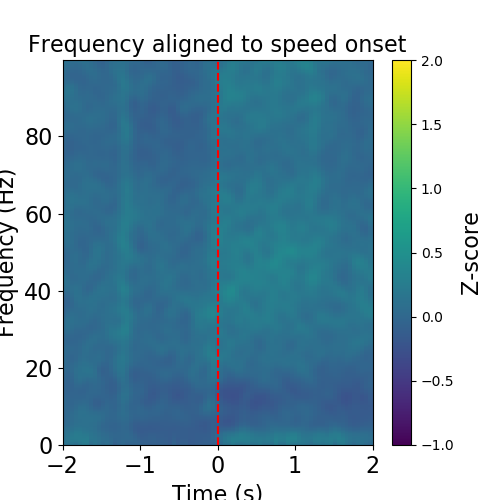

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


In [116]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

cutoff = 315 # -> don't plot above this frequency...
dt_speed = 1/data['1208_BaselineA']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
tPlot = np.linspace(-40*dt_speed,40*dt_speed,80)
dt_lfp = 1/data['1208_BaselineA']['lfp']['FS'][0]

de = {}
aligned = np.empty((tPlot.size,cutoff,0))
for s in data.keys():
    #find movment onset:
    speed = data[s]['mvmt']['speed']
    lfp = data[s]['lfp']['lfp']
    sOnset = FindMvmtOnset(speed,th =5,hi = 15)   
    # plot spectogram vs. speed onset:
    t_speed = np.linspace(0,len(speed)*dt_speed,len(speed))
    t_lfp = np.linspace(0,len(lfp)*dt_lfp,len(lfp))
    
    f, t, Sxx = signal.spectrogram(lfp, 1/dt_lfp,window=('hamming'),nperseg=140,noverlap =120,nfft=1200)
    sxx = interpolate.interp1d(t,Sxx,fill_value='extrapolate')
    
    dSpec = sxx(t_speed)
    mu = np.mean(dSpec, axis=2)
    std = np.std(dSpec, axis=2)
    for l in range(0,dSpec.shape[2]):
        dSpec[0,:,l] =(dSpec[0,:,l]-mu)/std
    
    al = alignToOnset(dSpec[0,0:cutoff,:].transpose(), sOnset, winPost =40, winPre = 40)
    aligned = np.concatenate((aligned,al), axis = 2)
    
d = np.mean(aligned,axis=2)
im = ax.pcolormesh(tPlot,f[0:cutoff],d.transpose(),vmin =-1,vmax=2 )
cbar=plt.colorbar(im,ax=ax)
cbar.set_label(label='Z-score',size=16)
ax.axvline(x=0.0,color='red',linestyle='dashed')
ax.set_title('Frequency aligned to speed onset',fontsize=16)
ax.set_ylabel('Frequency (Hz)',fontsize=16)
ax.set_xlabel('Time (s)',fontsize=16)
ax.tick_params(axis = 'y',labelsize=16)
ax.tick_params(axis = 'x',labelsize=16)


<IPython.core.display.Javascript object>


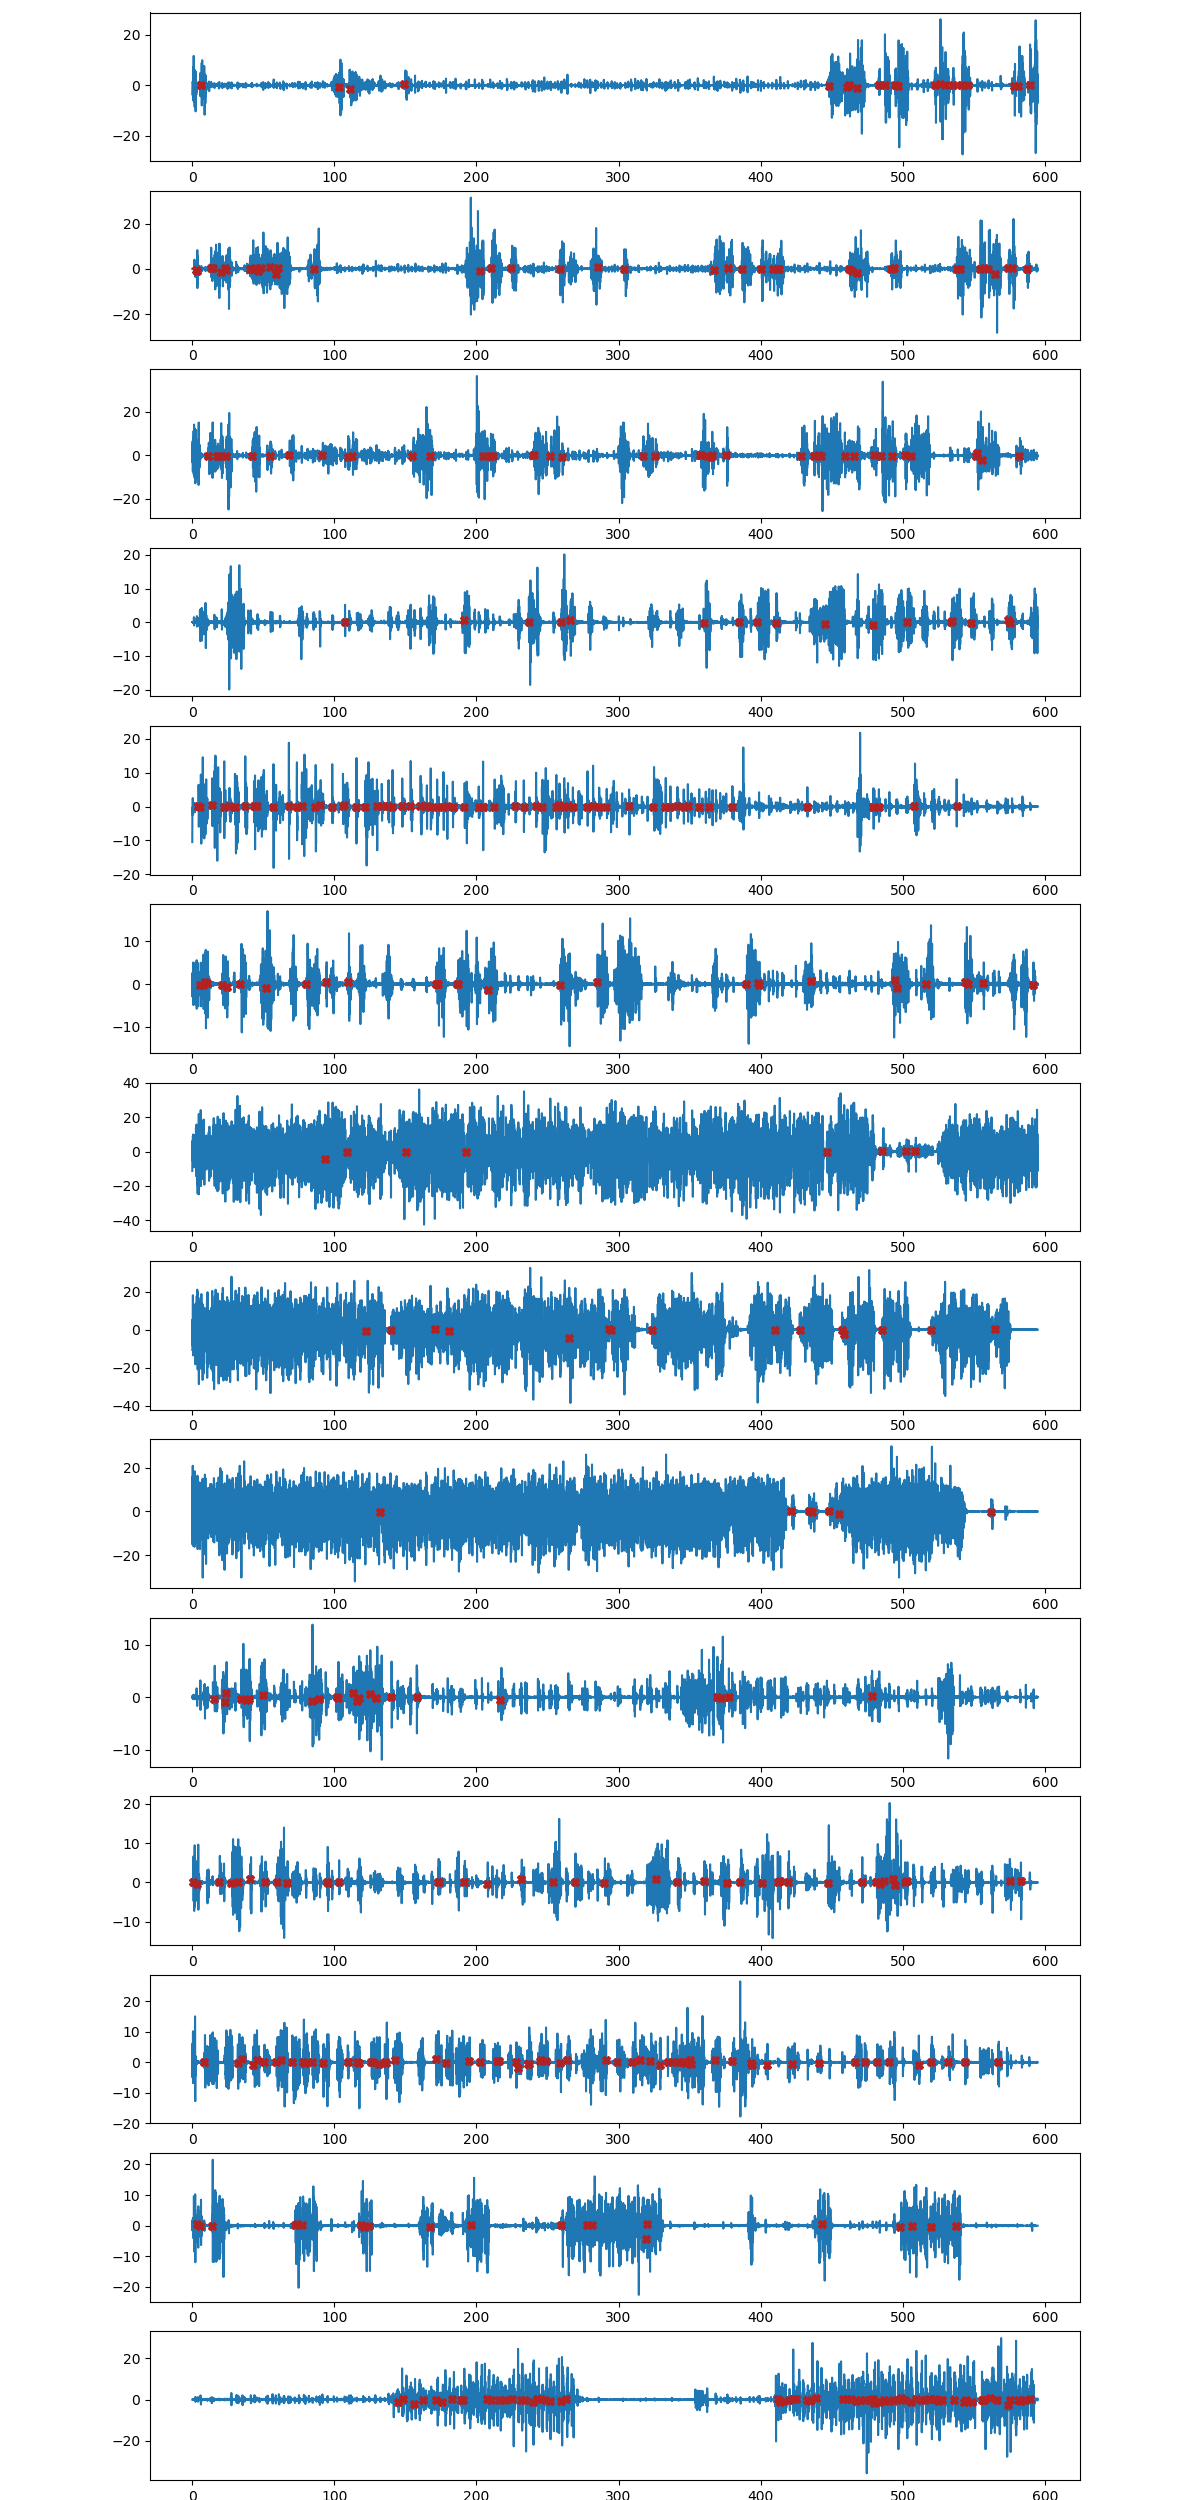

In [94]:
fig, ax = plt.subplots(len(data.keys()),1,figsize=(12, 25),gridspec_kw = {'top':0.995,'bottom':0.008,'wspace':0.3})

de = {}

dt = 1/data['1208_BaselineA']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt... 
#tPlot = np.linspace(-40*dt,40*dt,80)

sessNum = 0
for s in data.keys():
    #find movment onset:
    acc = np.diff(data[s]['mvmt']['speed'])
    sOnset = FindMvmtOnset(acc,th =1,hi = 5)   
    # plot speed vd. onset:
    t = np.linspace(0,len(acc)*dt,len(acc))
    ax[sessNum].plot(t,acc)
    ax[sessNum].plot(t[sOnset],acc[sOnset],'X',color='firebrick')
    sessNum = sessNum +1


because there aren't any current CHI session, remove from cond list: 

<IPython.core.display.Javascript object>


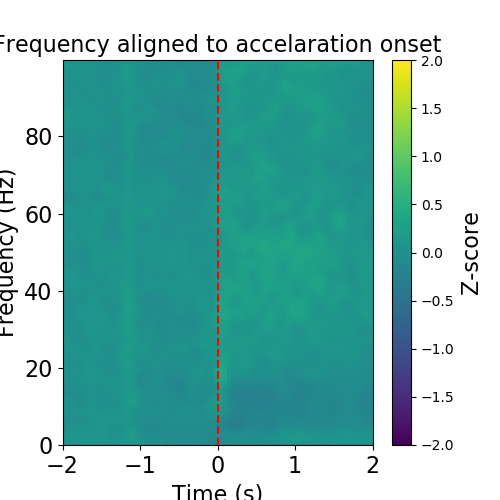

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


In [117]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

cutoff = 315 # -> don't plot above this frequency...
dt_acc = 1/data['1208_BaselineA']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
tPlot = np.linspace(-40*dt_acc,40*dt_acc,80)
dt_lfp = 1/data['1208_BaselineA']['lfp']['FS'][0]

de = {}
aligned = np.empty((tPlot.size,cutoff,0))
for s in data.keys():
    #find movment onset:
    acc = np.diff(data[s]['mvmt']['speed'])
    lfp = data[s]['lfp']['lfp']
    sOnset = FindMvmtOnset(acc,th =1,hi = 5)   
    # plot spectogram vs. acc onset:
    t_acc = np.linspace(0,len(acc)*dt_acc,len(acc))
    t_lfp = np.linspace(0,len(lfp)*dt_lfp,len(lfp))
    
    f, t, Sxx = signal.spectrogram(lfp, 1/dt_lfp,window=('hamming'),nperseg=140,noverlap =120,nfft=1200)
    sxx = interpolate.interp1d(t,Sxx,fill_value='extrapolate')
    
    dSpec = sxx(t_acc)
    mu = np.mean(dSpec, axis=2)
    std = np.std(dSpec, axis=2)
    for l in range(0,dSpec.shape[2]):
        dSpec[0,:,l] =(dSpec[0,:,l]-mu)/std
    
    al = alignToOnset(dSpec[0,0:cutoff,:].transpose(), sOnset, winPost =40, winPre = 40)
    aligned = np.concatenate((aligned,al), axis = 2)
    
d = np.mean(aligned,axis=2)
im = ax.pcolormesh(tPlot,f[0:cutoff],d.transpose(),vmin =-2,vmax=2)
cbar=plt.colorbar(im,ax=ax)
cbar.set_label(label='Z-score',size=16)
ax.axvline(x=0.0,color='red',linestyle='dashed')
ax.set_title('Frequency aligned to accelaration onset',fontsize=16)
ax.set_ylabel('Frequency (Hz)',fontsize=16)
ax.set_xlabel('Time (s)',fontsize=16)
ax.tick_params(axis = 'y',labelsize=16)
ax.tick_params(axis = 'x',labelsize=16)


<IPython.core.display.Javascript object>


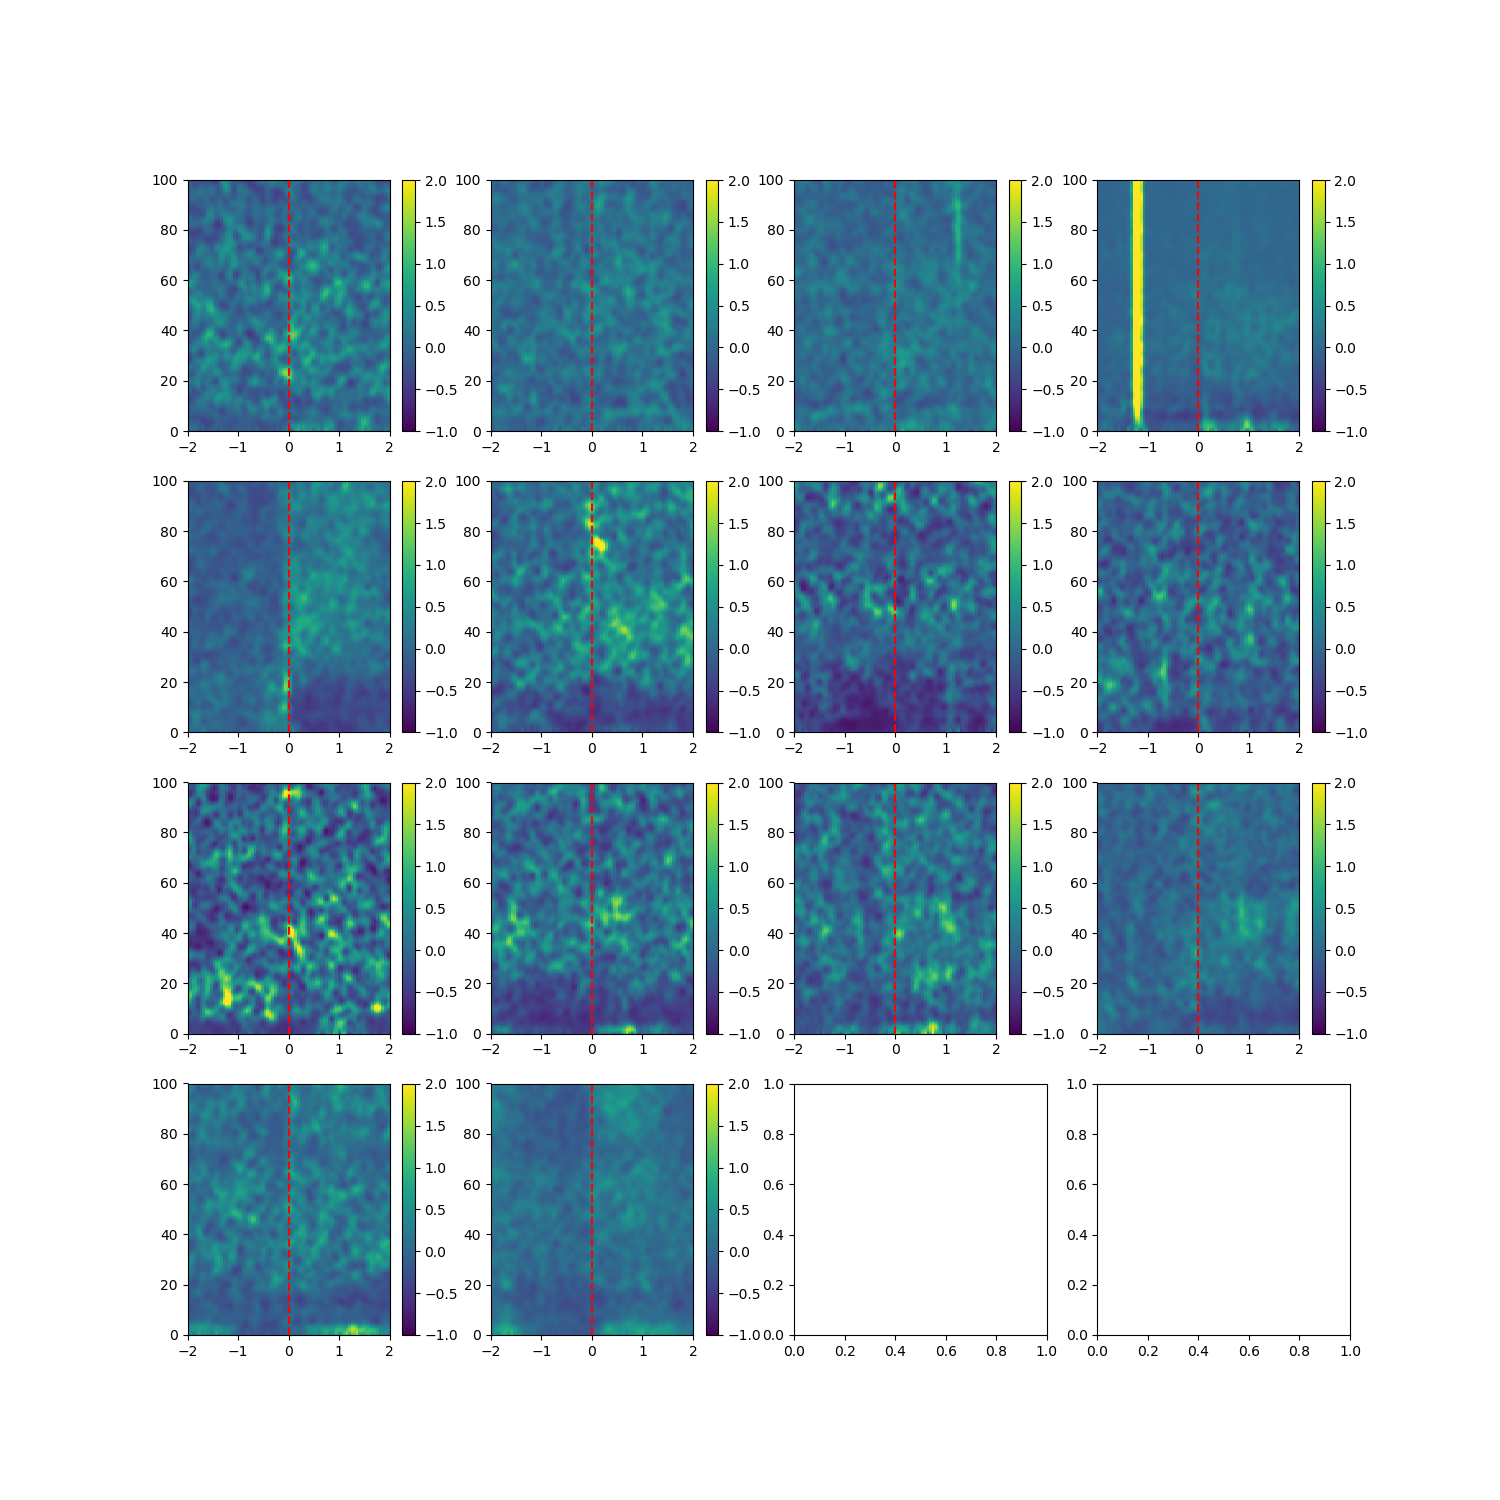

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


In [150]:
fig, ax = plt.subplots(4,4,figsize=(15,15))

cutoff = 315 # -> don't plot above this frequency...
dt_speed = 1/data['1208_BaselineA']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
tPlot = np.linspace(-40*dt_speed,40*dt_speed,80)
dt_lfp = 1/data['1208_BaselineA']['lfp']['FS'][0]

sNum = 0
#aligned = np.empty((tPlot.size,cutoff,0))
for s in data.keys():
    #find movment onset:
    speed = data[s]['mvmt']['speed']
    lfp = data[s]['lfp']['lfp']
    sOnset = FindMvmtOnset(speed,th =5,hi = 15)   
    # plot spectogram vs. speed onset:
    t_speed = np.linspace(0,len(speed)*dt_speed,len(speed))
    t_lfp = np.linspace(0,len(lfp)*dt_lfp,len(lfp))
    
    f, t, Sxx = signal.spectrogram(lfp, 1/dt_lfp,window=('hamming'),nperseg=140,noverlap =120,nfft=1200)
    sxx = interpolate.interp1d(t,Sxx,fill_value='extrapolate')
    
    dSpec = sxx(t_speed)
    mu = np.mean(dSpec, axis=2)
    std = np.std(dSpec, axis=2)
    for l in range(0,dSpec.shape[2]):
        dSpec[0,:,l] =(dSpec[0,:,l]-mu)/std
    
    al = alignToOnset(dSpec[0,0:cutoff,:].transpose(), sOnset, winPost =40, winPre = 40)
    #aligned = np.concatenate((aligned,al), axis = 2)
    
    d = np.mean(al,axis=2)
    im = ax[int(np.floor(sNum/4)),sNum%4].pcolormesh(tPlot,f[0:cutoff],d.transpose(),vmin =-1,vmax=2 )
    cbar=plt.colorbar(im,ax=ax[int(np.floor(sNum/4)),sNum%4])
  #  cbar.set_label(label='Z-score',size=16)
    ax[int(np.floor(sNum/4)),sNum%4].axvline(x=0.0,color='red',linestyle='dashed')
   # ax[int(np.floor(sNum/4)),sNum%4].set_title('Frequency aligned to speed onset',fontsize=16)
   # ax[int(np.floor(sNum/4)),sNum%4].set_ylabel('Frequency (Hz)',fontsize=16)
   # ax[int(np.floor(sNum/4)),sNum%4].set_xlabel('Time (s)',fontsize=16)
   # ax[int(np.floor(sNum/4)),sNum%4].tick_params(axis = 'y',labelsize=16)
   # ax[int(np.floor(sNum/4)),sNum%4].tick_params(axis = 'x',labelsize=16)
    sNum = sNum+1

<IPython.core.display.Javascript object>


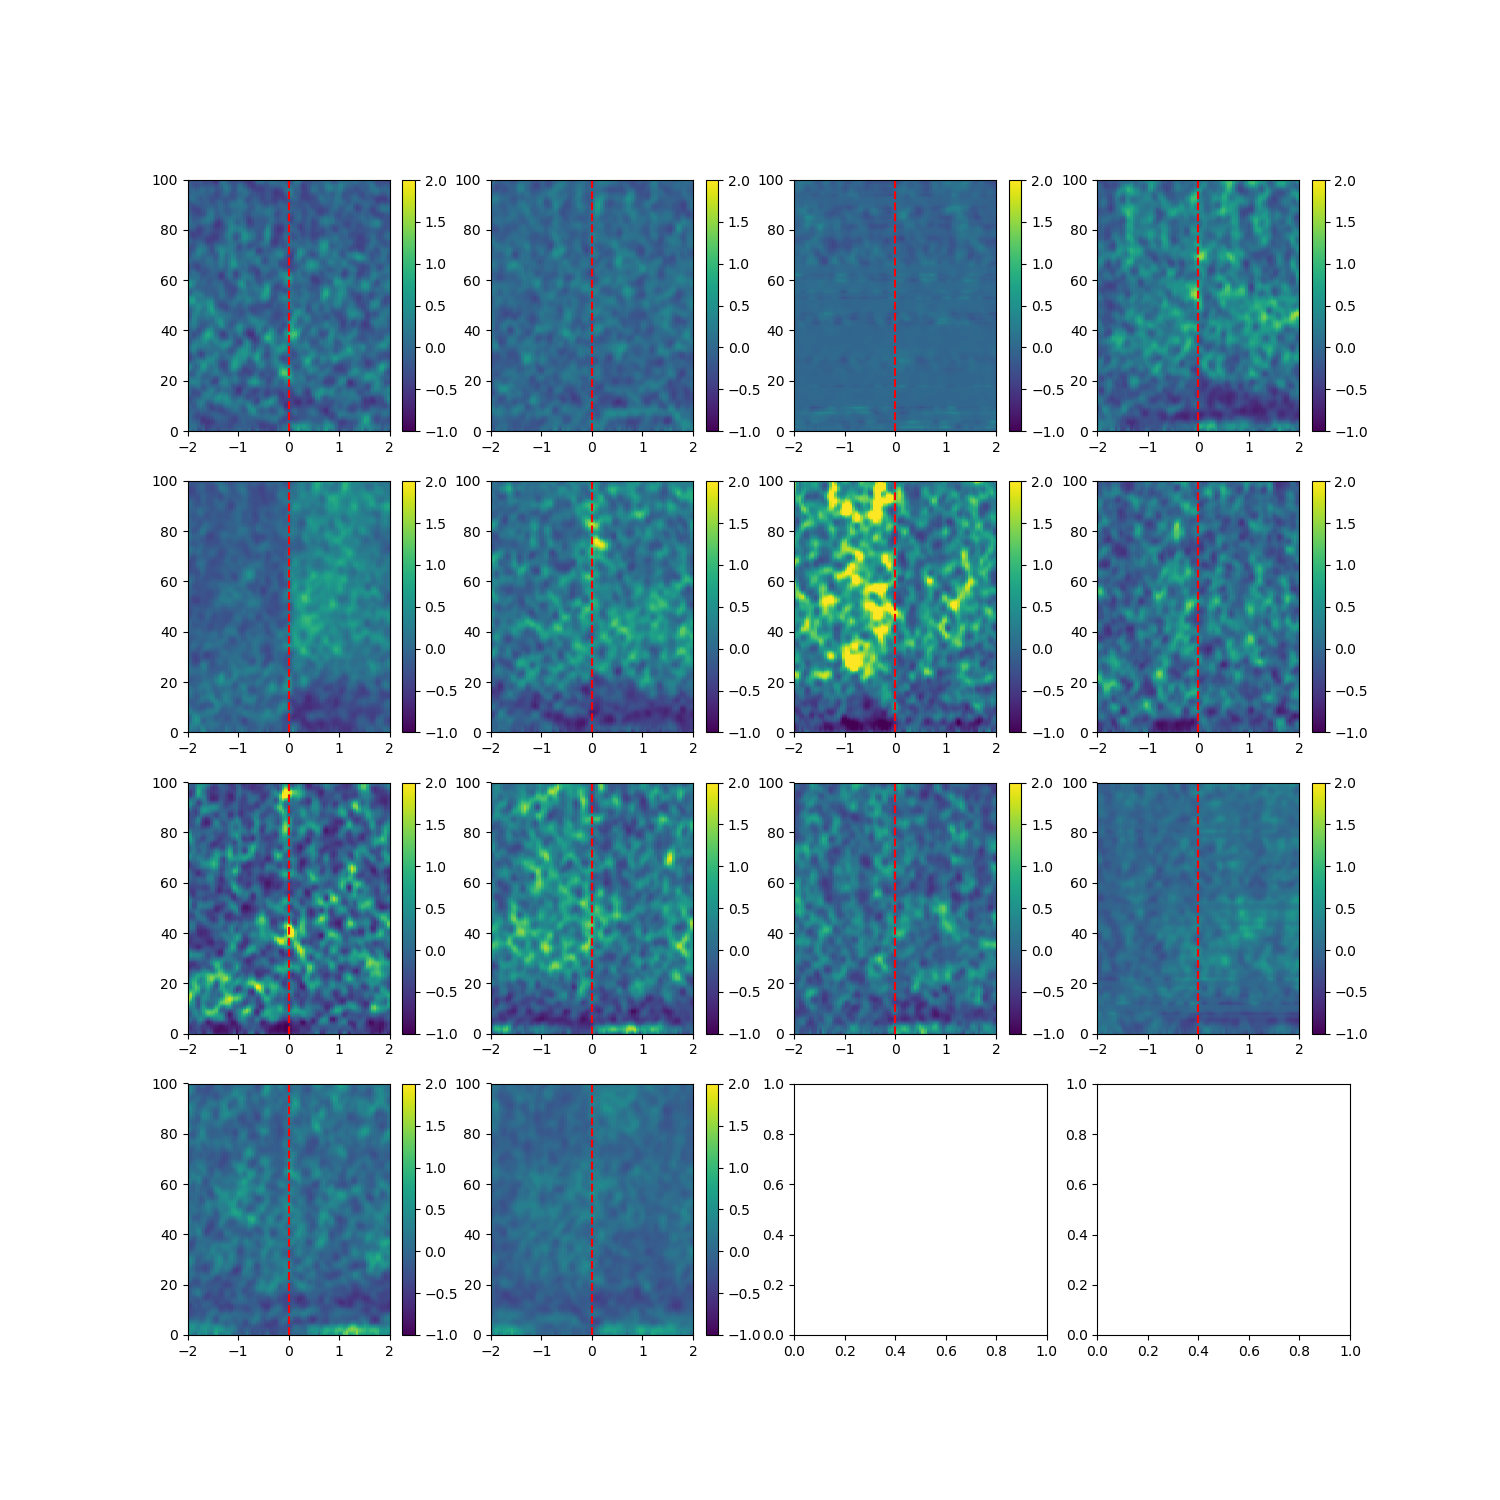

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


In [152]:
fig, ax = plt.subplots(4,4,figsize=(15,15))

cutoff = 315 # -> don't plot above this frequency...
dt_speed = 1/data['1208_BaselineA']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
tPlot = np.linspace(-40*dt_speed,40*dt_speed,80)
dt_lfp = 1/data['1208_BaselineA']['lfp']['FS'][0]

sNum = 0
#aligned = np.empty((tPlot.size,cutoff,0))
for s in data.keys():
    #find movment onset:
    speed = data[s]['mvmt']['speed']
    lfp = data[s]['lfp']['lfp']
    sOnset = FindMvmtOnset(speed,th =5,hi = 15)   
    # plot spectogram vs. speed onset:
    t_speed = np.linspace(0,len(speed)*dt_speed,len(speed))
    t_lfp = np.linspace(0,len(lfp)*dt_lfp,len(lfp))
    
    f, t, Sxx = signal.spectrogram(lfp, 1/dt_lfp,window=('hamming'),nperseg=140,noverlap =120,nfft=1200)
    sxx = interpolate.interp1d(t,Sxx,fill_value='extrapolate')
    
    dSpec = sxx(t_speed)
    dSpec = dSpec/np.sum(dSpec,axis=1)
    mu = np.mean(dSpec, axis=2)
    std = np.std(dSpec, axis=2)
    for l in range(0,dSpec.shape[2]):
        dSpec[0,:,l] =(dSpec[0,:,l]-mu)/std
    
    al = alignToOnset(dSpec[0,0:cutoff,:].transpose(), sOnset, winPost =40, winPre = 40)
    #aligned = np.concatenate((aligned,al), axis = 2)
    
    d = np.mean(al,axis=2)
    im = ax[int(np.floor(sNum/4)),sNum%4].pcolormesh(tPlot,f[0:cutoff],d.transpose(),vmin =-1,vmax=2 )
    cbar=plt.colorbar(im,ax=ax[int(np.floor(sNum/4)),sNum%4])
  #  cbar.set_label(label='Z-score',size=16)
    ax[int(np.floor(sNum/4)),sNum%4].axvline(x=0.0,color='red',linestyle='dashed')
   # ax[int(np.floor(sNum/4)),sNum%4].set_title('Frequency aligned to speed onset',fontsize=16)
   # ax[int(np.floor(sNum/4)),sNum%4].set_ylabel('Frequency (Hz)',fontsize=16)
   # ax[int(np.floor(sNum/4)),sNum%4].set_xlabel('Time (s)',fontsize=16)
   # ax[int(np.floor(sNum/4)),sNum%4].tick_params(axis = 'y',labelsize=16)
   # ax[int(np.floor(sNum/4)),sNum%4].tick_params(axis = 'x',labelsize=16)
    sNum = sNum+1

<h2> determine high and low velocity periods </h2>

<IPython.core.display.Javascript object>


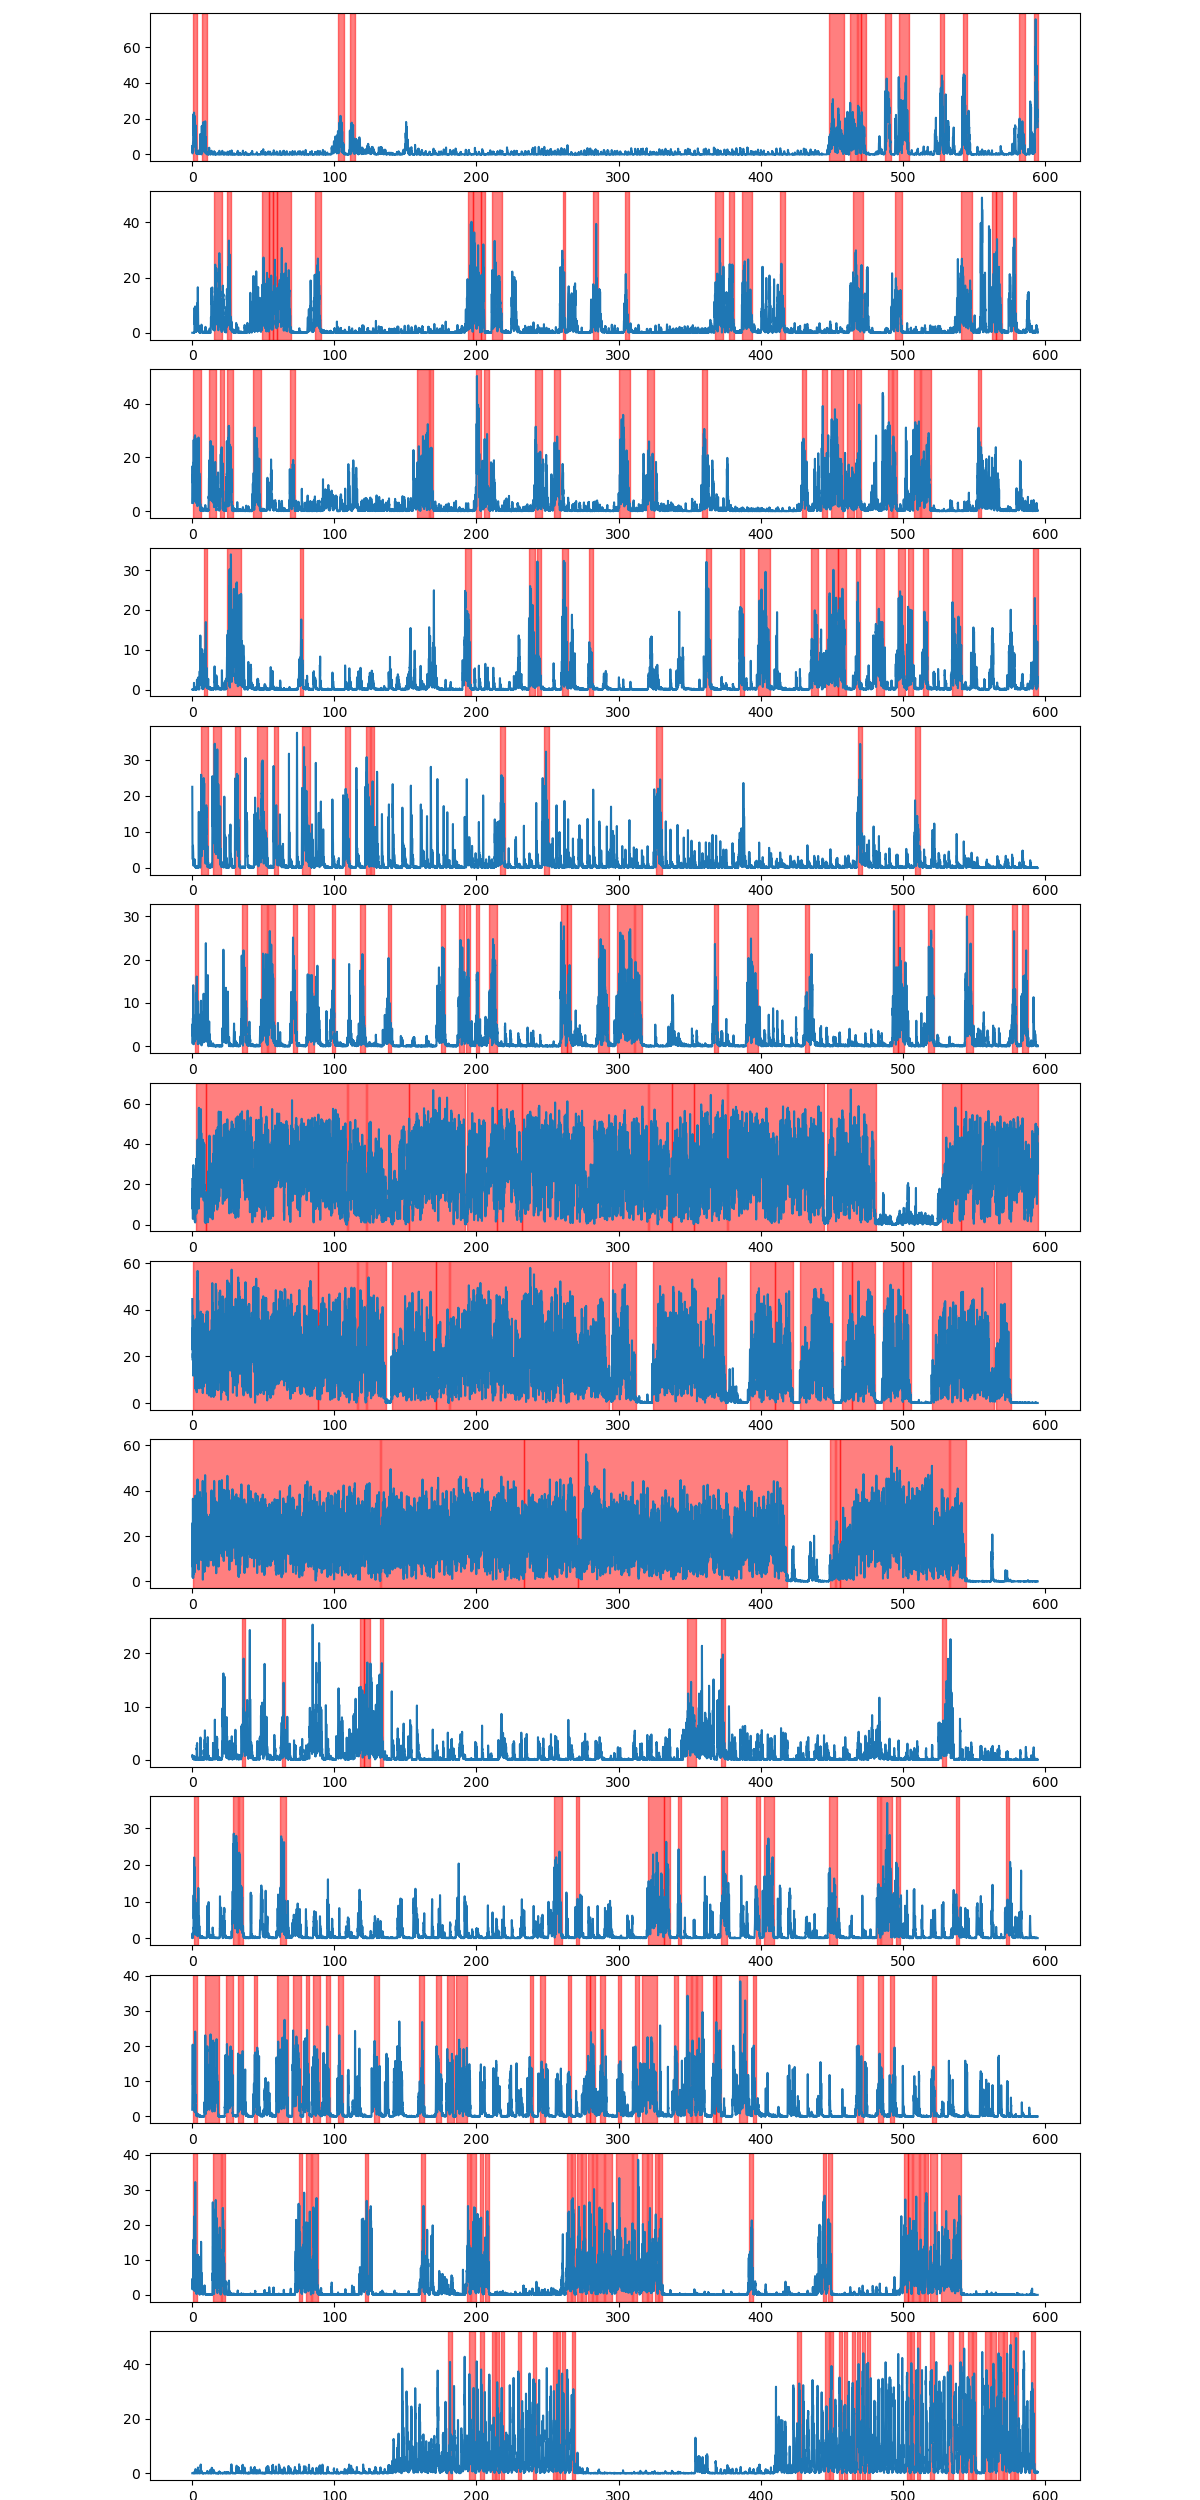

In [195]:
fig, ax = plt.subplots(len(data.keys()),1,figsize=(12, 25),gridspec_kw = {'top':0.995,'bottom':0.008,'wspace':0.3})

dt = 1/data['1208_BaselineA']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
#tPlot = np.linspace(-40*dt,40*dt,80)
Tseconds = 2
dataPoints = int(np.ceil(Tseconds/dt))

sessNum = 0
for s in data.keys():
    #find movment onset:
    speed = data[s]['mvmt']['speed']
    lspeed =  butter_lowpass_filter(speed, 1, 1/dt, order=5)
    hiSpeed = lspeed >= 3
    d = np.diff(1* hiSpeed)
    segments = {'start':[],'end':[]}
    
    if hiSpeed[0] ==1:
        tStart = 0
    else:
        tStart = None
        
    for l in range(0,len(d)):
        if d[l] == 1:
            tStart = l
        if d[l] == -1 and l-tStart > dataPoints:
            segments['start'].append(tStart)
            segments['end'].append(l)
            tStart = None
            
    if tStart is not None and np.sum(hiSpeed[tStart:]) > dataPoints:
        segments['start'].append(tStart)
        segments['end'].append(len(hiSpeed)-1)
    data[s]['highSpeed'] = segments
    # plot speed vd. onset:
    t = np.linspace(0,len(speed)*dt,len(speed))
    ax[sessNum].plot(t,speed)
    for l in range(0, len(segments['start'])):
        ax[sessNum].axvspan(t[segments['start'][l]], t[segments['end'][l]], color='red', alpha=0.5)
    sessNum = sessNum +1

<IPython.core.display.Javascript object>


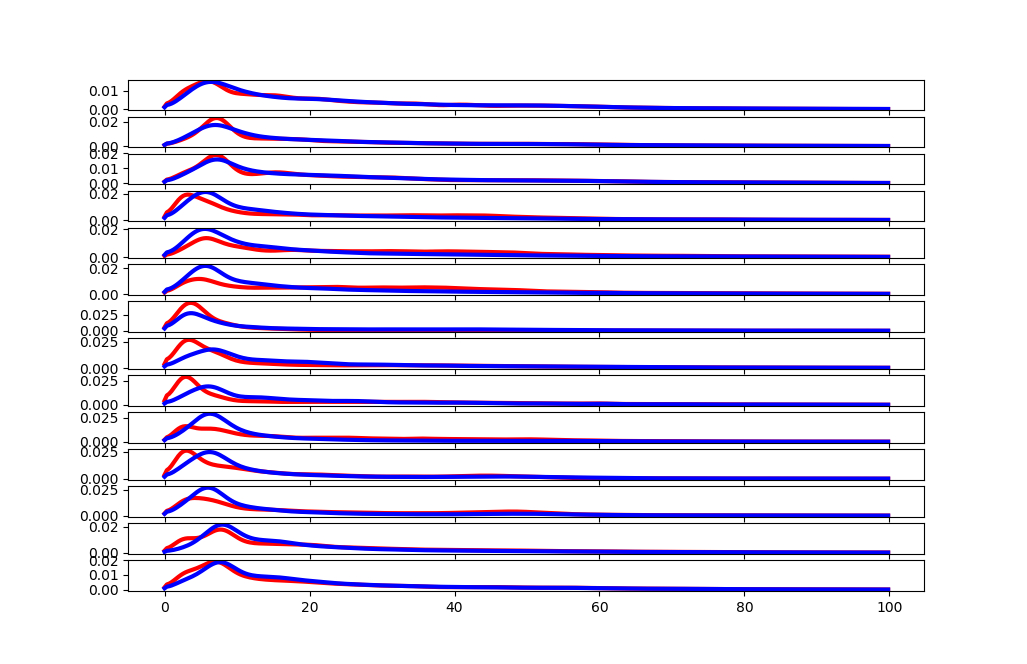

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


In [257]:
fig, ax = plt.subplots(14,1)

cutoff = 315 # -> don't plot above this frequency...
dt_speed = 1/data['1208_BaselineA']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
tPlot = np.linspace(-40*dt_speed,40*dt_speed,80)
dt_lfp = 1/data['1208_BaselineA']['lfp']['FS'][0]

sNum = 0
phigh = []
#aligned = np.empty((tPlot.size,cutoff,0))
for s in data.keys():
    #find movment onset:
    speed = data[s]['mvmt']['speed']
    lfp = data[s]['lfp']['lfp']
    #sOnset = FindMvmtOnset(speed,th =5,hi = 15)   
    # plot spectogram vs. speed onset:
    t_speed = np.linspace(0,len(speed)*dt_speed,len(speed))
    t_lfp = np.linspace(0,lfp.size*dt_lfp,lfp.size)
    
    f, t, Sxx = signal.spectrogram(lfp, 1/dt_lfp,window=('hamming'),nperseg=140,noverlap =120,nfft=1200)
    sxx = interpolate.interp1d(t,Sxx,fill_value='extrapolate')
    
    dSpec = sxx(t_lfp) 
    tLow = np.ones(t_lfp.shape,dtype=bool)
    thigh = np.zeros(t_lfp.shape, dtype=bool)
    #al = alignToOnset(dSpec[0,0:cutoff,:].transpose(), sOnset, winPost =40, winPre = 40)
    al = np.empty((1,cutoff))
    for l in range(0, len(data[s]['highSpeed']['start'])):
        ts = t_speed[data[s]['highSpeed']['start'][l]]
        te =t_speed[data[s]['highSpeed']['end'][l]]
        ind =  [i for (i, val) in enumerate(t_lfp) if (val>ts and val<te)]
        tLow[ind] = False
        thigh[ind] = True
    
    PowerHigh = np.sum(dSpec[0,0:cutoff,thigh],axis=0)
    PowerLow = np.sum(dSpec[0,0:cutoff,tLow],axis=0)
    totPowerHigh = np.sum(PowerHigh)
    totPoweLow = np.sum(PowerLow)
    
#    phigh.append(Power/totPower)    
    phigh = PowerHigh/totPowerHigh
    plow = PowerLow/totPoweLow
#    phigh = np.array(phigh)
#    M = np.nanmean(phigh,axis=0)
#    Std = np.nanstd(phigh, axis = 0)
    ax[sNum].plot(f[0:cutoff], phigh, linewidth=3,color='red')
    ax[sNum].plot(f[0:cutoff], plow, linewidth=3,color='blue')
    sNum = sNum+1 
#    ax[sNum].fill_between(f[0:cutoff], M-Std, M+Std,color='blue',alpha=0.1)

In [1]:
data.keys()

NameError: name 'data' is not defined

<IPython.core.display.Javascript object>


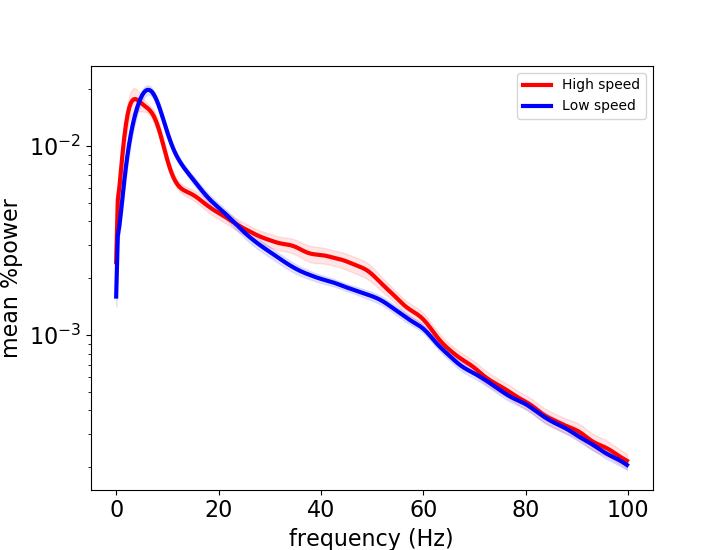

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


In [279]:
fig, ax = plt.subplots(1,1)

cutoff = 315 # -> don't plot above this frequency...
dt_speed = 1/data['1208_BaselineA']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
tPlot = np.linspace(-40*dt_speed,40*dt_speed,80)
dt_lfp = 1/data['1208_BaselineA']['lfp']['FS'][0]

sNum = 0
phigh = []
plow = []
#aligned = np.empty((tPlot.size,cutoff,0))
for s in data.keys():
    #find movment onset:
    speed = data[s]['mvmt']['speed']
    lfp = data[s]['lfp']['lfp']
    #sOnset = FindMvmtOnset(speed,th =5,hi = 15)   
    # plot spectogram vs. speed onset:
    t_speed = np.linspace(0,len(speed)*dt_speed,len(speed))
    t_lfp = np.linspace(0,lfp.size*dt_lfp,lfp.size)
    
    f, t, Sxx = signal.spectrogram(lfp, 1/dt_lfp,window=('hamming'),nperseg=140,noverlap =120,nfft=1200)
    sxx = interpolate.interp1d(t,Sxx,fill_value='extrapolate')
    
    dSpec = sxx(t_lfp) 
    tLow = np.ones(t_lfp.shape,dtype=bool)
    thigh = np.zeros(t_lfp.shape, dtype=bool)
    #al = alignToOnset(dSpec[0,0:cutoff,:].transpose(), sOnset, winPost =40, winPre = 40)
    al = np.empty((1,cutoff))
    for l in range(0, len(data[s]['highSpeed']['start'])):
        ts = t_speed[data[s]['highSpeed']['start'][l]]
        te =t_speed[data[s]['highSpeed']['end'][l]]
        ind =  [i for (i, val) in enumerate(t_lfp) if (val>ts and val<te)]
        tLow[ind] = False
        thigh[ind] = True
    
    PowerHigh = np.sum(dSpec[0,0:cutoff,thigh],axis=0)
    PowerLow = np.sum(dSpec[0,0:cutoff,tLow],axis=0)
    totPowerHigh = np.sum(PowerHigh)
    totPoweLow = np.sum(PowerLow)
    
#    phigh.append(Power/totPower)    
    phigh.append(PowerHigh/totPowerHigh)
    plow.append(PowerLow/totPoweLow)
phigh = np.array(phigh)
plow = np.array(plow)
Mhigh = np.nanmean(phigh,axis=0)
Mlow = np.nanmean(plow,axis=0)
Stdhigh = np.nanstd(phigh, axis = 0)/np.sqrt(14)
Stdlow = np.nanstd(plow, axis = 0)/np.sqrt(14)
ax.semilogy(f[0:cutoff], Mhigh, linewidth=3,color='red', label='High speed')
ax.semilogy(f[0:cutoff], Mlow, linewidth=3,color='blue', label='Low speed')
ax.fill_between(f[0:cutoff], Mhigh-Stdhigh, Mhigh+Stdhigh,color='red',alpha=0.1)
ax.fill_between(f[0:cutoff], Mlow-Stdlow, Mlow+Stdlow,color='blue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=16)
ax.set_xlabel('frequency (Hz)',fontsize=16)
ax.tick_params(labelsize=16)
ax.legend()

<IPython.core.display.Javascript object>


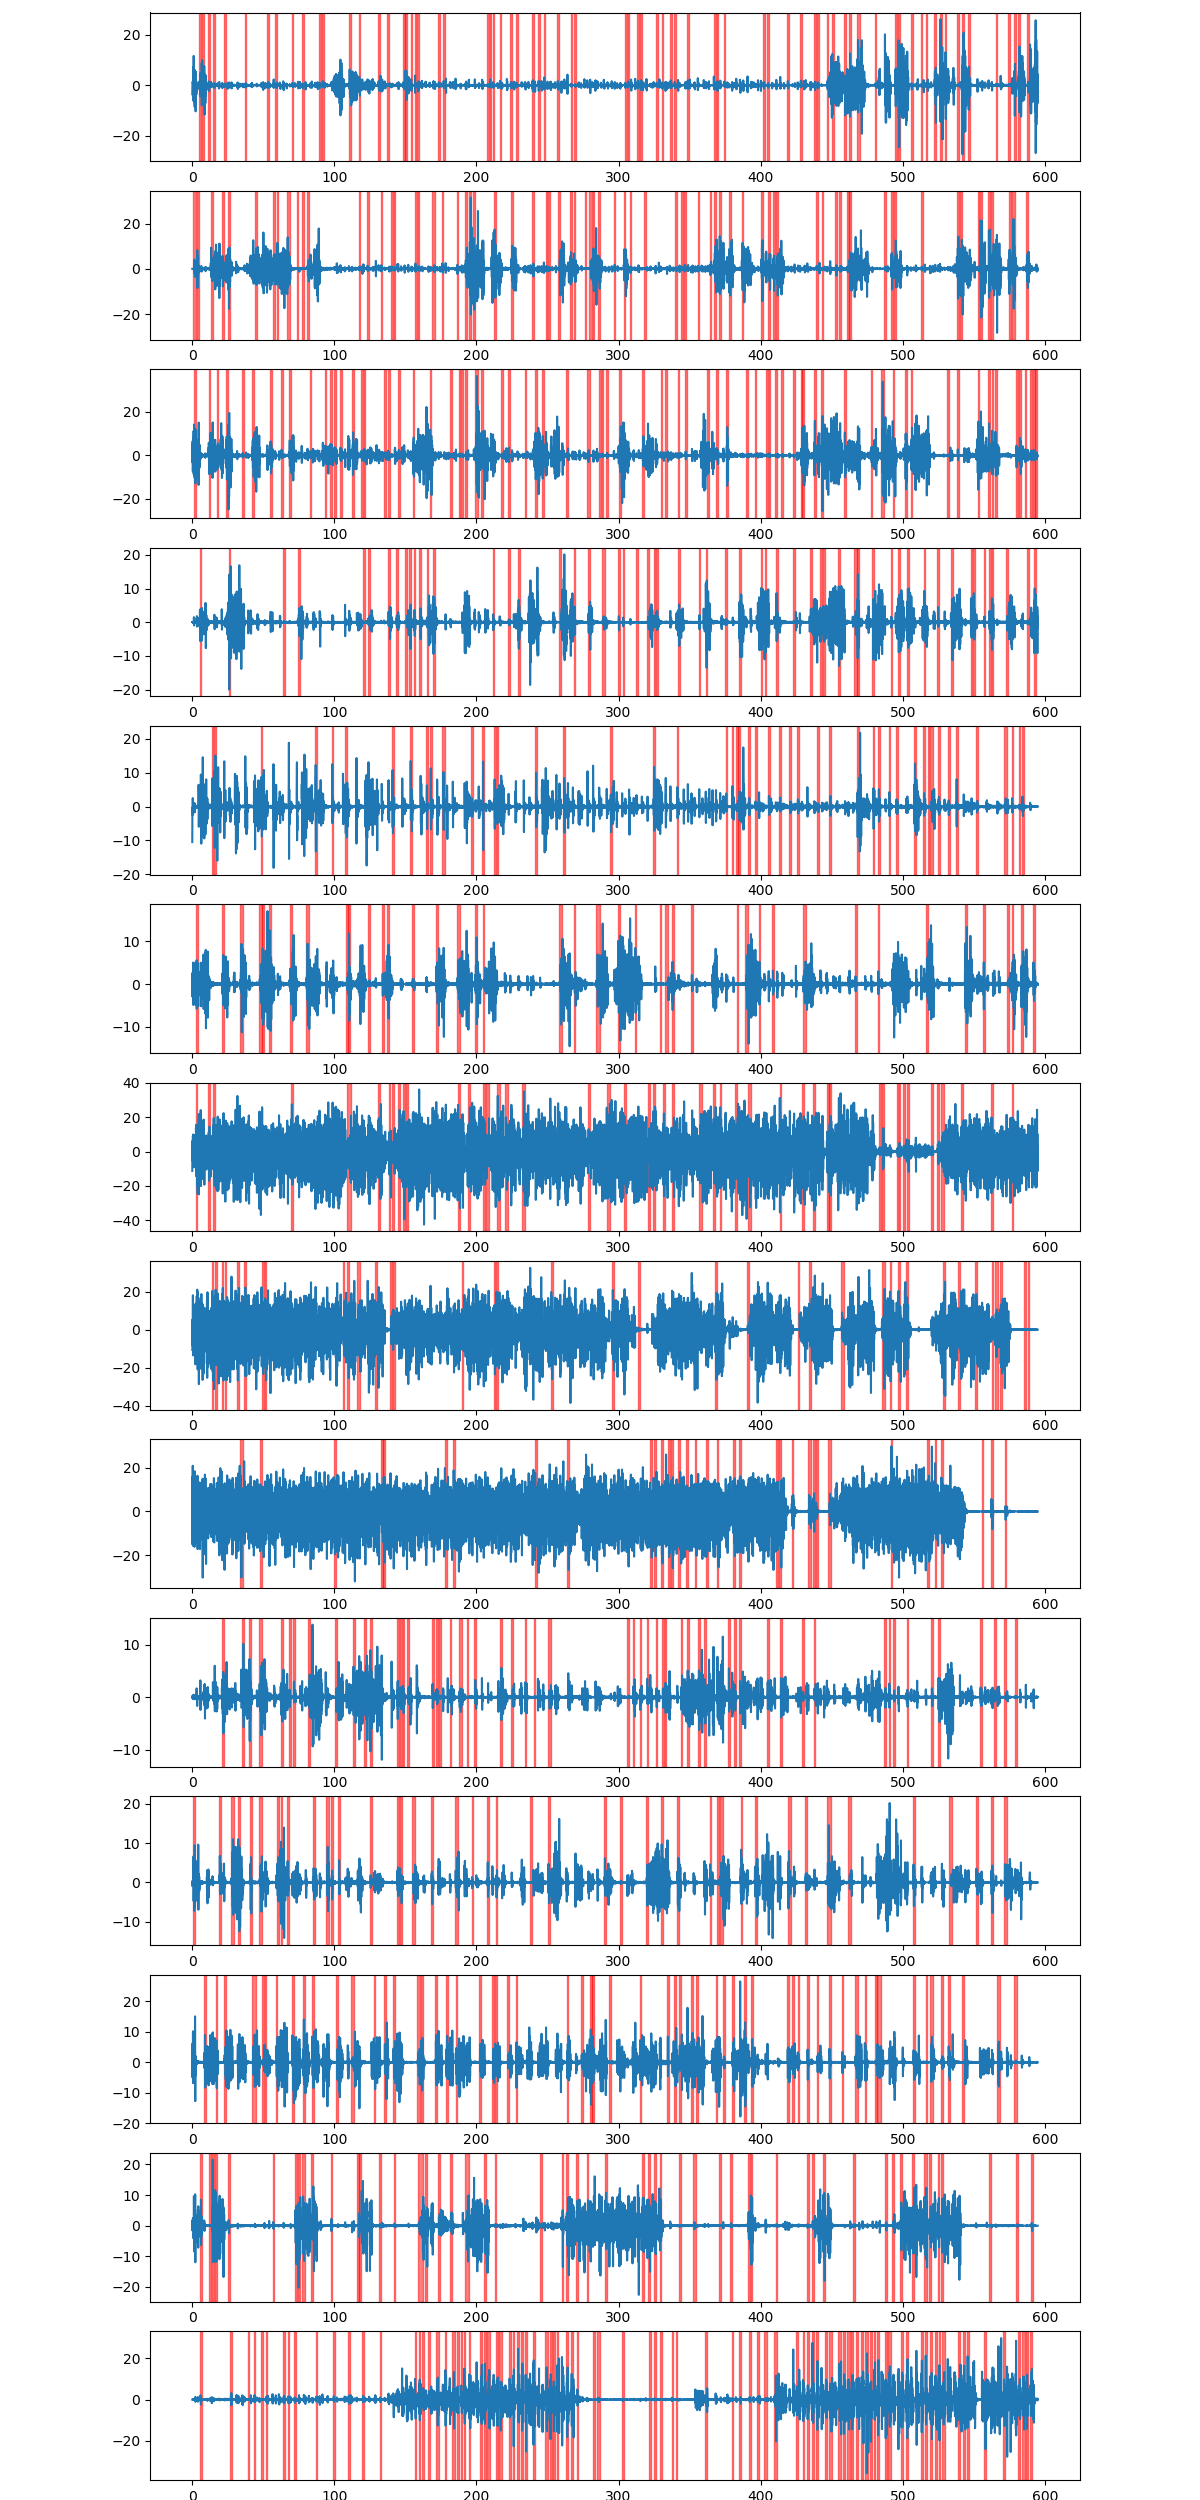

In [269]:
fig, ax = plt.subplots(len(data.keys()),1,figsize=(12, 25),gridspec_kw = {'top':0.995,'bottom':0.008,'wspace':0.3})

dt = 1/data['1208_BaselineA']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
#tPlot = np.linspace(-40*dt,40*dt,80)
Tseconds = 1
dataPoints = int(np.ceil(Tseconds/dt))

sessNum = 0
for s in data.keys():
    #find movment onset:
    acc = np.diff(data[s]['mvmt']['speed'])
    lspeed =  butter_lowpass_filter(acc, 1, 1/dt, order=5)
    hiSpeed = lspeed > 0
    d = np.diff(1* hiSpeed)
    segments = {'start':[],'end':[]}
    
    if hiSpeed[0] ==1:
        tStart = 0
    else:
        tStart = None
        
    for l in range(0,len(d)):
        if d[l] == 1:
            tStart = l
        if d[l] == -1 and l-tStart > dataPoints:
            segments['start'].append(tStart)
            segments['end'].append(l)
            tStart = None
            
    if tStart is not None and np.sum(hiSpeed[tStart:]) > dataPoints:
        segments['start'].append(tStart)
        segments['end'].append(len(hiSpeed)-1)
    data[s]['highAcc'] = segments
    # plot speed vd. onset:
    t = np.linspace(0,len(acc)*dt,len(acc))
    ax[sessNum].plot(t,acc)
    for l in range(0, len(segments['start'])):
        ax[sessNum].axvspan(t[segments['start'][l]], t[segments['end'][l]], color='red', alpha=0.5)
    sessNum = sessNum +1

<IPython.core.display.Javascript object>


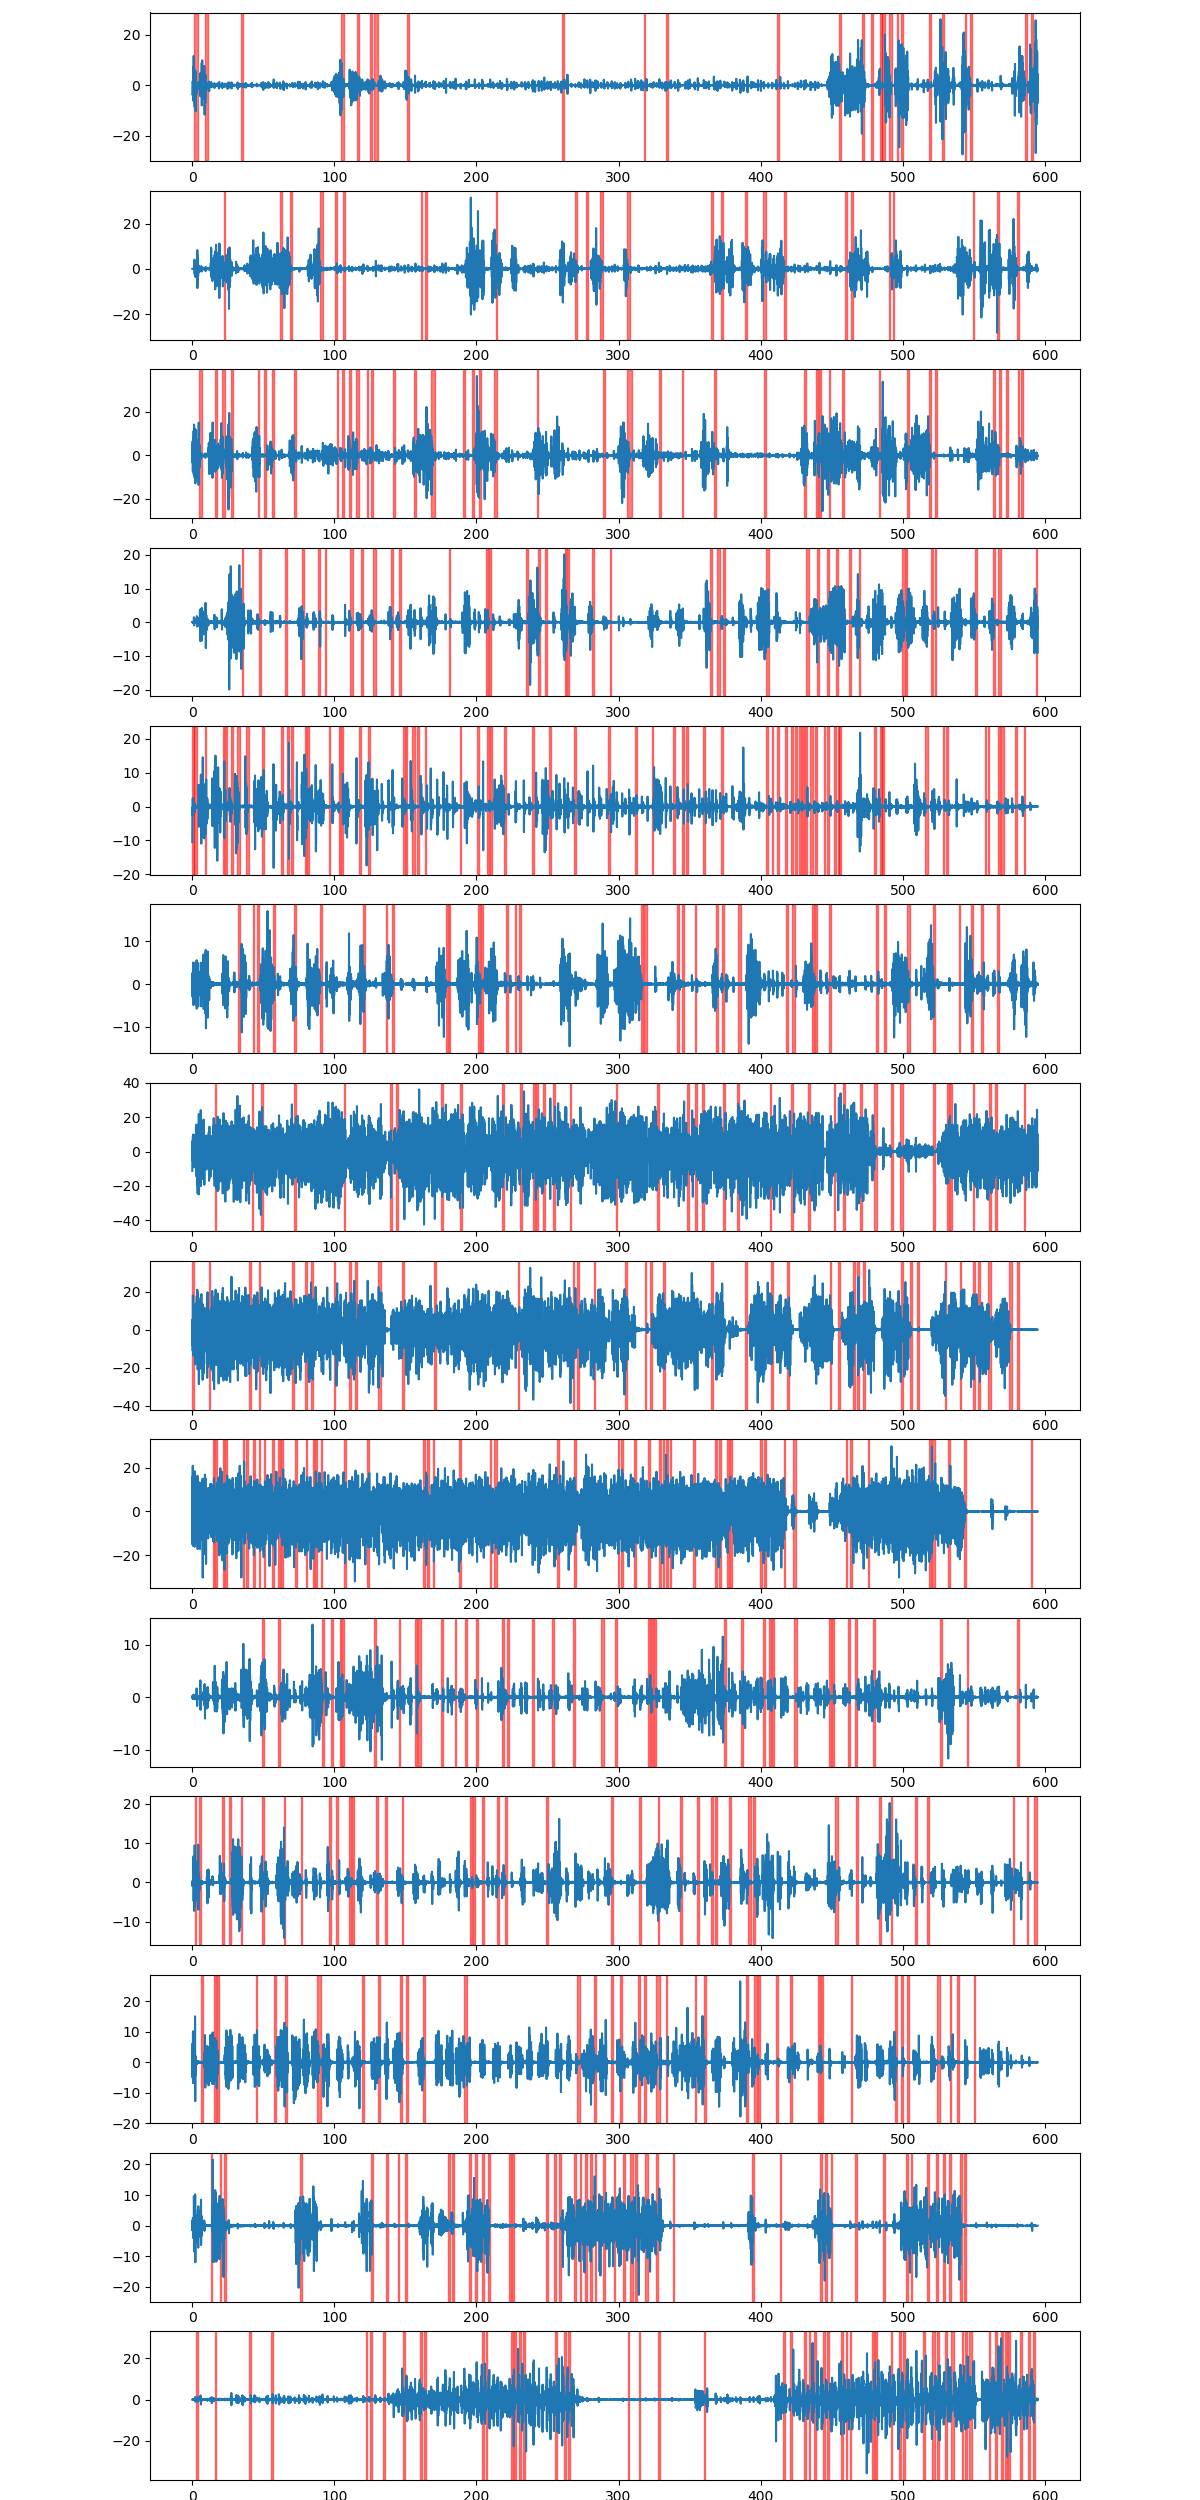

In [267]:
fig, ax = plt.subplots(len(data.keys()),1,figsize=(12, 25),gridspec_kw = {'top':0.995,'bottom':0.008,'wspace':0.3})

dt = 1/data['1208_BaselineA']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
#tPlot = np.linspace(-40*dt,40*dt,80)
Tseconds = 1
dataPoints = int(np.ceil(Tseconds/dt))

sessNum = 0
for s in data.keys():
    #find movment onset:
    acc = np.diff(data[s]['mvmt']['speed'])
    lspeed =  butter_lowpass_filter(acc, 1, 1/dt, order=5)
    hiSpeed = lspeed < 0
    d = np.diff(1* hiSpeed)
    segments = {'start':[],'end':[]}
    
    if hiSpeed[0] ==1:
        tStart = 0
    else:
        tStart = None
        
    for l in range(0,len(d)):
        if d[l] == 1:
            tStart = l
        if d[l] == -1 and l-tStart > dataPoints:
            segments['start'].append(tStart)
            segments['end'].append(l)
            tStart = None
            
    if tStart is not None and np.sum(hiSpeed[tStart:]) > dataPoints:
        segments['start'].append(tStart)
        segments['end'].append(len(hiSpeed)-1)
    data[s]['lowAcc'] = segments
    # plot speed vd. onset:
    t = np.linspace(0,len(acc)*dt,len(acc))
    ax[sessNum].plot(t,acc)
    for l in range(0, len(segments['start'])):
        ax[sessNum].axvspan(t[segments['start'][l]], t[segments['end'][l]], color='red', alpha=0.5)
    sessNum = sessNum +1

<IPython.core.display.Javascript object>


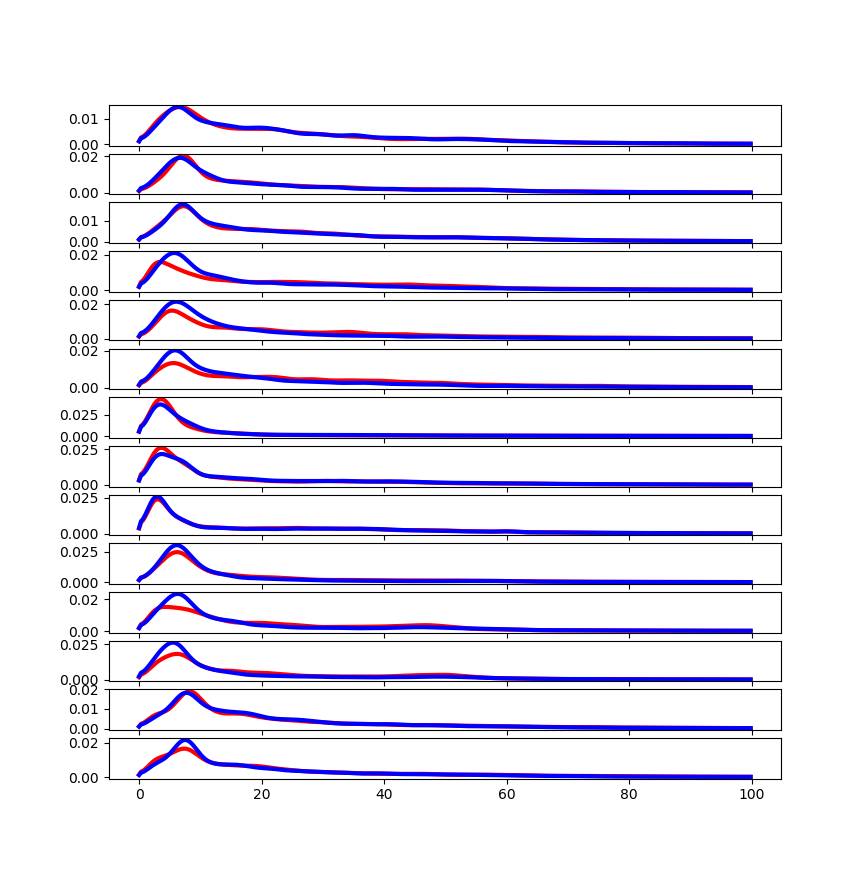

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


In [268]:
fig, ax = plt.subplots(14,1)

cutoff = 315 # -> don't plot above this frequency...
dt_speed = 1/data['1208_BaselineA']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
tPlot = np.linspace(-40*dt_speed,40*dt_speed,80)
dt_lfp = 1/data['1208_BaselineA']['lfp']['FS'][0]

sNum = 0
phigh = []
#aligned = np.empty((tPlot.size,cutoff,0))
for s in data.keys():
    #find movment onset:
    speed = data[s]['mvmt']['speed']
    lfp = data[s]['lfp']['lfp']
    #sOnset = FindMvmtOnset(speed,th =5,hi = 15)   
    # plot spectogram vs. speed onset:
    t_speed = np.linspace(0,len(speed)*dt_speed,len(speed))
    t_lfp = np.linspace(0,lfp.size*dt_lfp,lfp.size)
    
    f, t, Sxx = signal.spectrogram(lfp, 1/dt_lfp,window=('hamming'),nperseg=140,noverlap =120,nfft=1200)
    sxx = interpolate.interp1d(t,Sxx,fill_value='extrapolate')
    
    dSpec = sxx(t_lfp) 
    tLow = np.zeros(t_lfp.shape,dtype=bool)
    thigh = np.zeros(t_lfp.shape, dtype=bool)
    #al = alignToOnset(dSpec[0,0:cutoff,:].transpose(), sOnset, winPost =40, winPre = 40)
    al = np.empty((1,cutoff))
    for l in range(0, len(data[s]['highAcc']['start'])):
        ts = t_speed[data[s]['highAcc']['start'][l]]
        te =t_speed[data[s]['highAcc']['end'][l]]
        ind =  [i for (i, val) in enumerate(t_lfp) if (val>ts and val<te)]
        thigh[ind] = True
        
    for l in range(0, len(data[s]['lowAcc']['start'])):
        ts = t_speed[data[s]['lowAcc']['start'][l]]
        te =t_speed[data[s]['lowAcc']['end'][l]]
        ind =  [i for (i, val) in enumerate(t_lfp) if (val>ts and val<te)]
        tLow[ind] = True
        
          
        
    
    PowerHigh = np.sum(dSpec[0,0:cutoff,thigh],axis=0)
    PowerLow = np.sum(dSpec[0,0:cutoff,tLow],axis=0)
    totPowerHigh = np.sum(PowerHigh)
    totPoweLow = np.sum(PowerLow)
    
#    phigh.append(Power/totPower)    
    phigh = PowerHigh/totPowerHigh
    plow = PowerLow/totPoweLow
#    phigh = np.array(phigh)
#    M = np.nanmean(phigh,axis=0)
#    Std = np.nanstd(phigh, axis = 0)
    ax[sNum].plot(f[0:cutoff], phigh, linewidth=3,color='red')
    ax[sNum].plot(f[0:cutoff], plow, linewidth=3,color='blue')
    sNum = sNum+1 
#    ax[sNum].fill_between(f[0:cutoff], M-Std, M+Std,color='blue',alpha=0.1)

In [270]:
phigh.shape

(315,)